Caricamento del modello Spacy per POS tagging, Dependency Parsing e NER...
Caricamento del modello SBERT per generare embeddings contestuali...


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Preprocessing dei documenti...
Generazione degli embeddings SBERT...
Ricerca dei parametri ottimali per il clustering...
Provo i parametri: {'dimensionality_reduction_method': 'umap', 'clustering_method': 'agglomerative', 'method_clustering': 'ward', 'n_components': 10, 'n_clusters': 5, 'min_cluster_size': 5, 'min_samples': None, 'use_umap': True}
Riduzione dimensionale completata usando UMAP con parallelizzazione
Avvio del clustering Agglomerativo con metodo di linkage: ward
Coefficiente di silhouette medio per Agglomerativo: 0.42809954
Davies-Bouldin Index per Agglomerativo: 0.8459535278100884
Calinski-Harabasz Index per Agglomerativo: 80.80871919436682
Risultati dei cluster salvati in cluster/agglomerative_cluster_results.json
Silhouette Score: 0.4281
Provo i parametri: {'dimensionality_reduction_method': 'umap', 'clustering_method': 'agglomerative', 'method_clustering': 'average', 'n_components': 10, 'n_clusters': 5, 'min_cluster_size': 5, 'min_samples': None, 'use_umap': True}
Rid

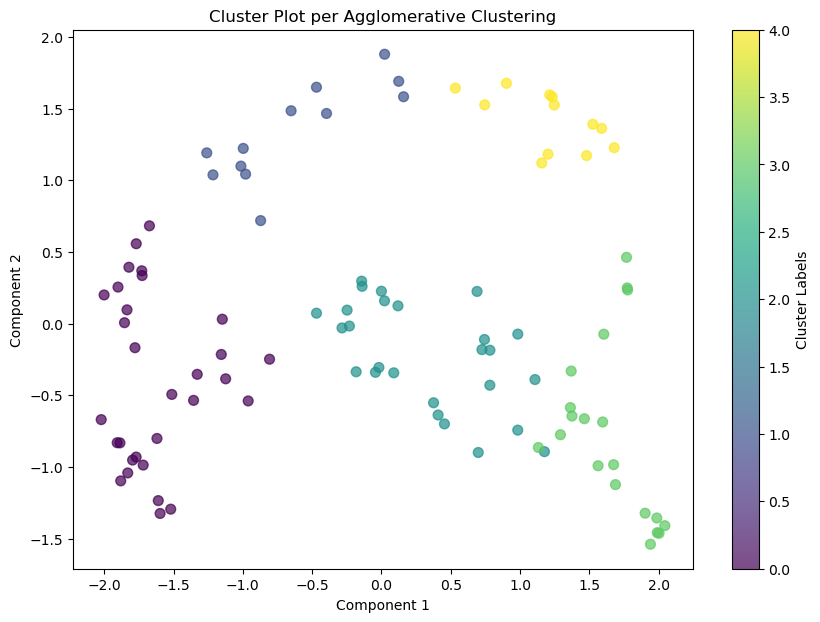

Risultati dei cluster salvati in cluster/agglomerative_cluster_results.json
Clustering agglomerative completato con Silhouette Score: 0.3945
Migliori parametri: {'dimensionality_reduction_method': 'tsne', 'clustering_method': 'hdbscan', 'method_clustering': 'ward', 'n_components': 10, 'n_clusters': 5, 'min_cluster_size': 5, 'min_samples': None, 'use_umap': True}
***************************************************

Eseguo il clustering hierarchical con i parametri ottimali...
Riduzione dimensionale completata usando UMAP con parallelizzazione
Avvio del clustering Gerarchico con metodo di linkage: ward
Coefficiente di silhouette medio per clustering Gerarchico: 0.43928885
Cophenetic Correlation Coefficient per clustering Gerarchico: 0.7006977708251082
Davies-Bouldin Index per clustering Gerarchico: 0.8077883056561337


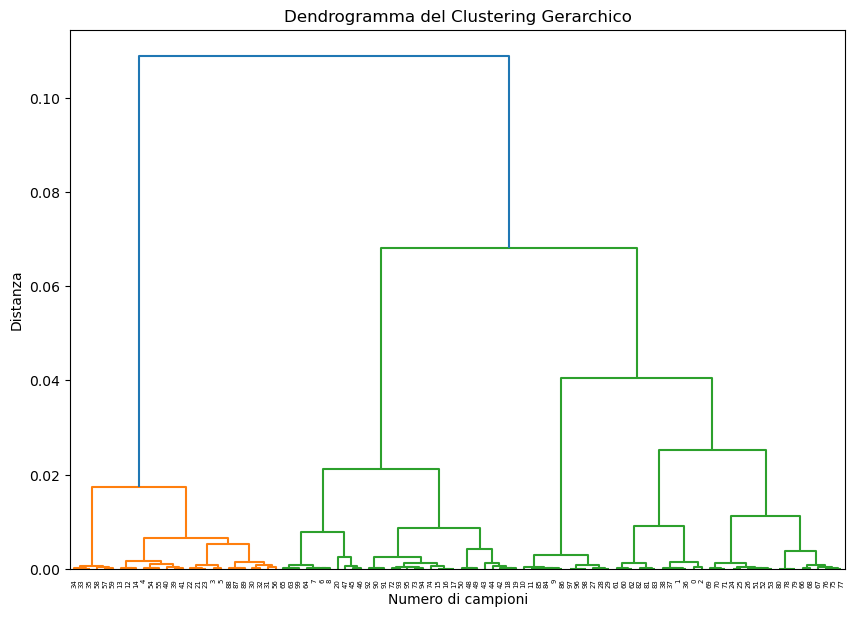

Risultati dei cluster salvati in cluster/hierarchical_cluster_results.json
Clustering hierarchical completato con Silhouette Score: 0.4393
Migliori parametri: {'dimensionality_reduction_method': 'tsne', 'clustering_method': 'hdbscan', 'method_clustering': 'ward', 'n_components': 10, 'n_clusters': 5, 'min_cluster_size': 5, 'min_samples': None, 'use_umap': True}
***************************************************

Eseguo il clustering hdbscan con i parametri ottimali...
Riduzione dimensionale completata usando UMAP con parallelizzazione
Avvio del clustering HDBSCAN con riduzione dimensionale UMAP...
Riduzione dimensionale completata usando UMAP con parallelizzazione
Coefficiente di silhouette medio per HDBSCAN: 0.43998796
Davies-Bouldin Index per HDBSCAN: 0.7403097474807093
Calinski-Harabasz Index per HDBSCAN: 63.89159566103056
Avviso: n_components è 10, quindi riduco a 2 dimensioni per il plotting.


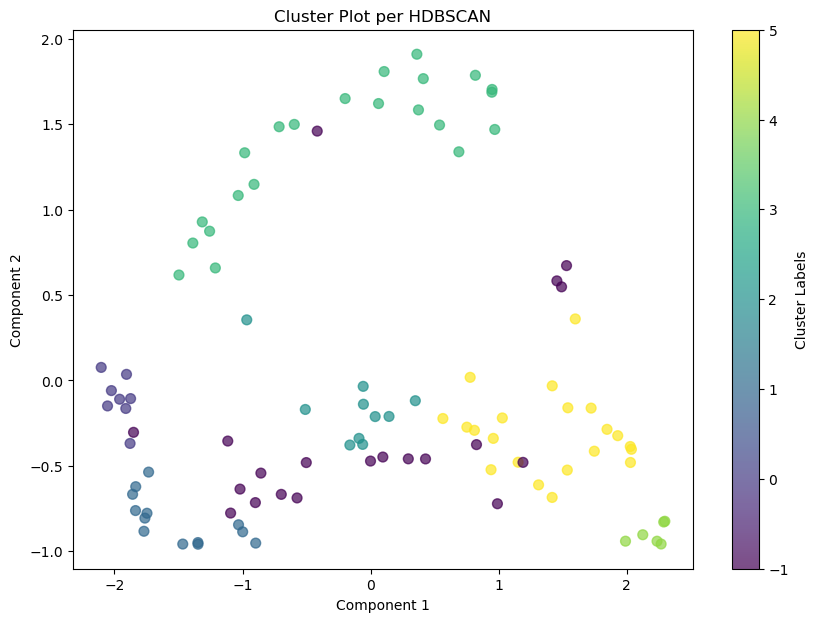

Risultati dei cluster salvati in cluster/hdbscan_cluster_results.json
Clustering hdbscan completato con Silhouette Score: 0.4400
Migliori parametri: {'dimensionality_reduction_method': 'tsne', 'clustering_method': 'hdbscan', 'method_clustering': 'ward', 'n_components': 10, 'n_clusters': 5, 'min_cluster_size': 5, 'min_samples': None, 'use_umap': True}
***************************************************


In [1]:
import gc
import json
import numpy as np
import pandas as pd
import spacy
import string
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from itertools import product
from scipy.spatial.distance import squareform
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import calinski_harabasz_score
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Caricamento di Spacy e SBERT
print("Caricamento del modello Spacy per POS tagging, Dependency Parsing e NER...")
nlp = spacy.load("en_core_web_lg")
print("Caricamento del modello SBERT per generare embeddings contestuali...")
sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Funzione per salvare i risultati dei cluster in formato JSON
def save_clusters_to_json(documents, labels, filename):
    clusters = defaultdict(list)
    for doc, label in zip(documents, labels):
        clusters[str(label)].append(doc)
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        json.dump(clusters, file, indent=4)
    print(f"Risultati dei cluster salvati in {filename}")

# Funzione per visualizzare il dendrogramma
def plot_clusters(data, labels=None, title="Plot dei Cluster", plot_type="scatter", original_n_components=2):
    plt.figure(figsize=(10, 7))
    
    if plot_type == "scatter":
        # Riduci a 2 dimensioni solo per il plotting se n_components > 2
        if original_n_components > 2:
            print(f"Avviso: n_components è {original_n_components}, quindi riduco a 2 dimensioni per il plotting.")
            data = PCA(n_components=2).fit_transform(data)
        
        scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        plt.colorbar(scatter, label='Cluster Labels')
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    
    elif plot_type == "dendrogram":
        # Assume che 'data' sia la linkage matrix
        dendrogram(data, truncate_mode='level', p=10)
        plt.xlabel("Numero di campioni")
        plt.ylabel("Distanza")
    
    else:
        raise ValueError("plot_type deve essere 'scatter' o 'dendrogram'")
    
    plt.title(title)
    plt.show()

# Funzione per preprocessare i documenti
def preprocess_text(text):
    # Converti in minuscolo e rimuovi la punteggiatura
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Esegui il processamento con spaCy
    doc = nlp(text)
    
    # Lemmatizza e rimuovi le stop words
    processed_tokens = [
        token.lemma_ for token in doc 
        if token.lemma_ not in nlp.Defaults.stop_words and not token.is_punct and not token.is_space
    ]
    
    # Unisci i token lemmatizzati in una singola stringa
    processed_text = ' '.join(processed_tokens)
    
    return processed_text


# Funzione per generare embeddings SBERT
def generate_sbert_embeddings(documents, use_batching=True):
    if use_batching:
        embeddings = sbert_model.encode(documents, convert_to_tensor=True, clean_up_tokenization_spaces=True, verbose=0)
        return embeddings.cpu().numpy()
    else:
        return np.vstack([sbert_model.encode(doc, clean_up_tokenization_spaces=True) for doc in documents])

# Funzione per riduzione dimensionale con UMAP o t-SNE, con opzione di parallelizzazione
def reduce_dimensions(data, method='umap', n_components=2, use_umap=True, parallelize=True):
    if use_umap:
        if parallelize:
            reducer = umap.UMAP(n_components=n_components, verbose=0)  # Senza random_state per parallelismo
        else:
            reducer = umap.UMAP(n_components=n_components, random_state=42, verbose=0)  # Con random_state per riproducibilità
    else:
        reducer = TSNE(n_components=n_components, random_state=42)
    
    reduced_data = reducer.fit_transform(data)
    print(f"Riduzione dimensionale completata usando {'UMAP' if use_umap else 't-SNE'} con {'parallelizzazione' if parallelize else 'riproducibilità'}")
    return reduced_data

# Funzione per il clustering KMeans con Calinski-Harabasz Index
def kmeans_clustering(data, n_clusters):
    print("Avvio del clustering KMeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=2, verbose=0)
    # Adatta il modello ai dati e predice le etichette
    labels = kmeans.fit_predict(data)
    # Calcola il coefficiente di silhouette
    silhouette_avg = silhouette_score(data, labels)
    # Calcola il Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(data, labels)
    # Calcola il Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(data, labels)
    
    print("Coefficiente di silhouette medio per KMeans:", silhouette_avg)
    print("Davies-Bouldin Index per KMeans:", davies_bouldin)
    print("Calinski-Harabasz Index per KMeans:", calinski_harabasz)
    
    return labels, silhouette_avg, davies_bouldin, calinski_harabasz

# Funzione per il clustering Agglomerativo con Calinski-Harabasz Index
def agglomerative_clustering(data, n_clusters, method_clustering):
    print("Avvio del clustering Agglomerativo con metodo di linkage:", method_clustering)
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=method_clustering)
    # Predice le etichette di clustering
    labels = agglomerative.fit_predict(data)
    # Calcola il coefficiente di silhouette
    silhouette_avg = silhouette_score(data, labels)
    # Calcola il Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(data, labels)
    # Calcola il Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(data, labels)
    
    print("Coefficiente di silhouette medio per Agglomerativo:", silhouette_avg)
    print("Davies-Bouldin Index per Agglomerativo:", davies_bouldin)
    print("Calinski-Harabasz Index per Agglomerativo:", calinski_harabasz)
    
    return labels, silhouette_avg, davies_bouldin, calinski_harabasz

# Funzione per il clustering Gerarchico
def hierarchical_clustering(data, n_clusters, method_clustering):
    print("Avvio del clustering Gerarchico con metodo di linkage:", method_clustering)
    # Calcola la matrice di distanza coseno
    cosine_distances = 1 - cosine_similarity(data)
    cosine_distances = np.maximum(cosine_distances, 0)
    # Converte la matrice di distanza quadrata in forma condensata
    condensed_distances = squareform(cosine_distances, checks=False)
    # Calcola il clustering gerarchico
    linkage_matrix = linkage(condensed_distances, method=method_clustering)
    # Genera le etichette di clustering
    labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    # Calcola il coefficiente di silhouette
    silhouette_avg = silhouette_score(data, labels)
    # Calcola il Cophenetic Correlation Coefficient
    coph_corr, _ = cophenet(linkage_matrix, pdist(data))
    # Calcola il Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(data, labels)
    
    print("Coefficiente di silhouette medio per clustering Gerarchico:", silhouette_avg)
    print("Cophenetic Correlation Coefficient per clustering Gerarchico:", coph_corr)
    print("Davies-Bouldin Index per clustering Gerarchico:", davies_bouldin)
    
    return labels, silhouette_avg, linkage_matrix, coph_corr, davies_bouldin

# Funzione per il clustering con UMAP e HDBSCAN
def hdbscan_clustering_with_umap(data, min_cluster_size=5, min_samples=None, n_components=2):
    print("Avvio del clustering HDBSCAN con riduzione dimensionale UMAP...")
    # Riduzione dimensionale con UMAP
    reduced_data = reduce_dimensions(data, method='umap', n_components=n_components, use_umap=True, parallelize=True)
    
    # Clustering HDBSCAN
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = hdbscan.fit_predict(reduced_data)
    
    # Rimuove i punti rumorosi per il calcolo delle metriche
    core_samples = reduced_data[labels != -1]
    core_labels = labels[labels != -1]
    
    # Calcola le metriche di clustering solo sui punti assegnati ai cluster
    if len(set(core_labels)) > 1:
        silhouette_avg = silhouette_score(core_samples, core_labels)
        davies_bouldin = davies_bouldin_score(core_samples, core_labels)
        calinski_harabasz = calinski_harabasz_score(core_samples, core_labels)
    else:
        silhouette_avg = davies_bouldin = calinski_harabasz = None
        print("HDBSCAN ha generato solo un cluster (o rumore) - non calcolo le metriche di qualità.")
    
    print("Coefficiente di silhouette medio per HDBSCAN:", silhouette_avg)
    print("Davies-Bouldin Index per HDBSCAN:", davies_bouldin)
    print("Calinski-Harabasz Index per HDBSCAN:", calinski_harabasz)
    
    return labels, silhouette_avg, davies_bouldin, calinski_harabasz, reduced_data

# Funzione per determinare i migliori parametri per il clustering
def find_optimal_clustering_params(documents, embeddings, param_grid):
    best_params = None
    best_score = -1

    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"Provo i parametri: {param_dict}")
        
        labels, score = clustering_with_dimensionality_reduction(
            documents,
            embeddings,
            n_clusters=param_dict['n_clusters'],
            method=param_dict['dimensionality_reduction_method'],
            clustering_method=param_dict['clustering_method'],
            n_components=param_dict['n_components'],
            use_umap=param_dict['use_umap'],
            method_clustering=param_dict['method_clustering'],
            plot_results=False  # Disabilita il plotting durante il grid search
        )
        
        print(f"Silhouette Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_params = param_dict
            
    print(f"Migliori parametri trovati: {best_params} con Silhouette Score: {best_score:.4f}")
    return best_params, best_score

def clustering_with_dimensionality_reduction(documents, embeddings, n_clusters=None, method='umap', clustering_method='kmeans', n_components=2, use_umap=True, method_clustering='ward', min_cluster_size=5, min_samples=None, plot_results=True):
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    reduced_data = reduce_dimensions(embeddings_scaled, method=method, n_components=n_components, use_umap=use_umap, parallelize=True)

    if clustering_method == 'kmeans':
        labels, score, davies_bouldin, calinski_harabasz = kmeans_clustering(reduced_data, n_clusters)
        gc.collect()
        if plot_results:
            plot_clusters(reduced_data, labels=labels, title="Cluster Plot per KMeans", plot_type="scatter", original_n_components=n_components)
        
    elif clustering_method == 'agglomerative':
        labels, score, davies_bouldin, calinski_harabasz = agglomerative_clustering(reduced_data, n_clusters, method_clustering)
        gc.collect()
        if plot_results:
            plot_clusters(reduced_data, labels=labels, title="Cluster Plot per Agglomerative Clustering", plot_type="scatter", original_n_components=n_components)
        
    elif clustering_method == 'hierarchical':
        labels, score, linkage_matrix, coph_corr, davies_bouldin = hierarchical_clustering(reduced_data, n_clusters, method_clustering)
        gc.collect()
        if plot_results:
            plot_clusters(linkage_matrix, title="Dendrogramma del Clustering Gerarchico", plot_type="dendrogram")
        
    elif clustering_method == 'hdbscan':
        # Call hdbscan_clustering_with_umap without `original_n_components`
        labels, score, davies_bouldin, calinski_harabasz, reduced_data = hdbscan_clustering_with_umap(
            embeddings_scaled, min_cluster_size=min_cluster_size, min_samples=min_samples, n_components=n_components
        )
        gc.collect()
        if plot_results:
            plot_clusters(reduced_data, labels=labels, title="Cluster Plot per HDBSCAN", plot_type="scatter", original_n_components=n_components)
    
    save_clusters_to_json(documents, labels, f"cluster/{clustering_method}_cluster_results.json")
    return labels, score

# Modifica il grid search per includere HDBSCAN
'''param_grid = {
    'dimensionality_reduction_method': ['umap', 'tsne'],
    'clustering_method': ['agglomerative', 'hierarchical', 'hdbscan', 'kmeans'],
    'method_clustering': ['ward','average','single','complete','weighted','centroid','median'],
    'n_components': [2, 5, 7, 10, 13, 15, 17, 20],
    'n_clusters': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'min_cluster_size': [5, 10, 15, 20, 25],  # Aggiunto per HDBSCAN
    'min_samples': [None, 1, 5, 10, 15],  # Aggiunto per HDBSCAN
    'use_umap': [True, False]
}'''

# Parametri di ricerca su griglia
param_grid = {
    'dimensionality_reduction_method': ['umap', 'tsne'],
    'clustering_method': ['agglomerative', 'hierarchical', 'hdbscan'],
    'method_clustering': ['ward', 'average', 'single', 'complete'],
    'n_components': [10],
    'n_clusters': [5],
    'min_cluster_size': [5],  # Aggiunto per HDBSCAN
    'min_samples': [None],  # Aggiunto per HDBSCAN
    'use_umap': [True]
}

# Caricamento del dataset
with open('stereoset_with_multivectors_for_clustering.json', 'r') as file:
    data = json.load(file)

# Preprocessing dei documenti e generazione degli embeddings
print("Preprocessing dei documenti...")
df = pd.DataFrame(data)
df = df.head(100)
documents = df['Frase'].tolist()

preprocess=False
if preprocess:
    documents = [preprocess_text(doc) for doc in documents]

print("Generazione degli embeddings SBERT...")
multivectors = generate_sbert_embeddings(documents, use_batching=True)

# Ricerca dei parametri ottimali
print("Ricerca dei parametri ottimali per il clustering...")
best_params, best_score = find_optimal_clustering_params(documents, multivectors, param_grid)

print("***************************************************")
# Clustering con i parametri ottimali per ogni metodo
for method in ['agglomerative', 'hierarchical', 'hdbscan']:
    print(f"\nEseguo il clustering {method} con i parametri ottimali...")
    labels, score = clustering_with_dimensionality_reduction(
        documents,
        multivectors,
        n_clusters=best_params['n_clusters'],
        method=best_params['dimensionality_reduction_method'],
        clustering_method=method,
        n_components=best_params['n_components'],
        use_umap=best_params['use_umap'],
        plot_results=True  # Abilita il plotting per il clustering finale
    )
    print(f"Clustering {method} completato con Silhouette Score: {score:.4f}")
    print(f"Migliori parametri: {best_params}")
    print("***************************************************")
